# Trabajo Practico - Desarrollo de software para el cálculo de parámetros acústicos ISO 3382 (2da entrega)

## Fecha de entrega

*18/10/2022*

## Integrantes

* <Tyler, Cruz>
* <Santiago, Franco>
* <Felipe, Merlo>

## Aspectos generales del notebook

* Todas las funciones deben contar con su [docstring](https://realpython.com/documenting-python-code/#docstring-types), como figura en la función de ejemplo (`ruidoRosa_voss`)(1er entrega).
* Todos los gráficos deben tener correctamente etiquetados los ejes.
* Enviar el notebook (.ipynb) completado y con las celdas ejecutas a myommi@untref.edu.ar.
* Todas las señales de audio deben ser grabadas en formato .wav en la misma función que las genera.

## Librerias utilizadas
Agregar todas las librerias utilizadas, algunas a modo de ejemplo:

In [76]:
import numpy as np
import soundfile as sf
import sounddevice as sd
from scipy import signal
from scipy.fftpack import fft, ifft
import pandas as pd

## Descargar dataset
El objetivo es tener archivos para validar el software creado , para lo cual es necesario contar con la información y los datos de la medición.

### 1. Respuestas al impulso: 
**Consigna:** Descargar **al menos dos** respuestas al impulso (RI o en ingles IR, Impulse Responses) de dos recintos distintos del siguiente [link](https://www.openair.hosted.york.ac.uk/?page_id=36) y toda la información relevante de la medición, ademas de los resultados de los parametros acústicos calculados (para luego comparar). También se pueden usar los archivos dispuestos en el Drive de la asignatura. 

### 2. Sine sweep logarítmico + filtro inverso: 
**Consigna:** Descargar **al menos un** sine sweep con su respectivo filtro inverso. Una posibildiad es usar los archivos dispuestos en el GDrive de la asignatura. Para generar el filtro inverso usar la info brindada por el informe técnico en la misma carpeta de los archivos. 

## Función de carga de archivos de audio

**Consigna:** realizar una función que permita cargar archivos de audio, en lo posible \*.wav, por ejemplo los archivos anteriormente descargados. Contemplar el ingreso de más de un archivo de audio, por tipo.

In [68]:
def lectura_wav(filename):
    """
    Lee un archivo de audio .wav ingresado.

    Parametros
    ----------
    filename : archivo de audio.

    Returns
    -------
    data : numpy array
        Array con información del audio.

    fs: int
        Frecuencia de muestreo del audio.
    """

    data, fs = sf.read(filename)

    return data, fs


def carga_wav(files):
    """
    Almacena los datos de los archivos de audio .wav ingresados.

    Parameters
    ----------
    files : lista
        Lista con los nombres de los archivos de audio.

    Returns
    -------
    audios : dict
        Diccionario que tiene los nombres de los archivos de audio como keys y como values una tupla que contiene el array de información del audio seguido por su frecuencia de muestreo (int).

    """

    files = np.array(files)
    audios = {}

    for i in range(files.size):
        data, fs = lectura_wav(files[i])
        audios[files[i]] = data, fs

    return audios

Llamar a la función con uno de los ejemplos anteriormente descargados y usar la función de visualización de la 1er entrega.

In [69]:
audios = carga_wav(['RI_1.wav', 'RI_2.wav'])


In [70]:
data_RI1, fs_RI1 = audios.get('RI_1.wav')
data_RI2, fs_RI2 = audios.get('RI_2.wav')


ValueError: x and y must have same first dimension, but have shapes (480002,) and (480001,)

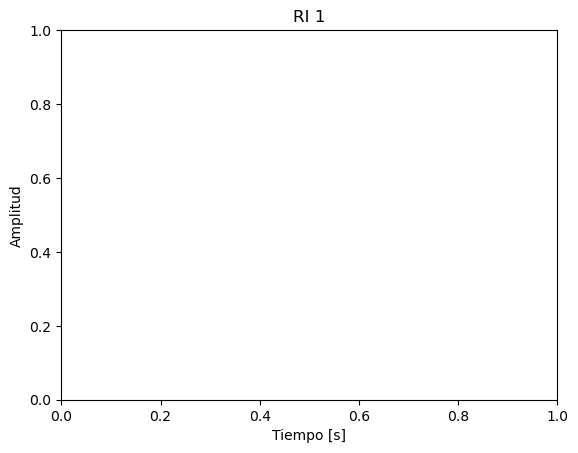

In [30]:
from funciones import grafico_señal

grafico_señal(data_RI1, fs_RI1, 'RI 1')
grafico_señal(data_RI2, fs_RI2, 'RI 2')  # Revisar error dimensiones


## Función de sintetización de respuesta al impulso

**Consigna:** realizar una función para sintetizar una respuesta al impulso. La misma recibira como parametro el $T60$ que se desea obtener, y deberá sintetizar una respuesta al impulso considerando las frecuencias centrales de banda de octava y tercio de octava como establece la norma IEC61260 (IEC61260,1995). La siguiente ecuación define una RI, para una frecuencia central $f_{i}$:

\begin{equation}
y_{i}=A_{i}e^{\tau_it}\cos(2πf_{i}t)
\tag{6}
\end{equation}

donde $A_{i}$ es el coeficiente de amplitud para esa $f_{i}$(puede ser 1), y  $π_{i}$ define el decaimiento exponencial en función de $T_{60_i}$ (tiempo de reverberación) para una frecuencia $f_{i}$.

\begin{equation}
\tau_i=-\frac{ln(10^{-3})}{T_{60_i}}
\tag{7}
\end{equation}

La suma de varias frecuencias centrales $f_{i}$ se define como:
\begin{equation}
  y=\sum_{y=1}^{n}y_{i}
\tag{8}
\end{equation}

Con $n$ la cantidad de frecuencias centrales $f_{i}$ del filtro. La funcion debe recibir el tiempo de reverberacion para cada frecuencia, y devolver la respuesta al impulso correspondiente como un archivo de audio .wav. Al momento de definir la función, buscar la forma de que la misma permita varios $T60_i$ para cada frecuencia. 

> Con esta funcion se busca obtener un archivo de audio de valores de $T60_i$ conocidos que permita probar el software.

In [66]:
def sintR(T60, T, fs, A=0.1, banda="octava"):
    """
    Función que sintetiza una respuesta al impulso calculando la RI de cada
    frecuencia central en bandas de octava o tercios de octava según la normativa
    IEC-611260.

    Parámetros
    ----------
    T : int
        Tiempo.

    fs : int
        Frecuencia de muestreo.

    A : float
        Factor de amplificación.

    banda = str
        String que puede ser "octava" para bandas de octava y "tercio" para tercios de octava.

    T60 : vector
        Vector con los tiempos de reverberación para cada frecuencia central.

    Returns
    ----------
    RI_sint : numpy array 
        Array con la información del impulso sintetizado.

    """

    N = T*fs  # Cantidad de muestras
    t = np.linspace(0, T, N)  # Eje x

    if banda == "octava":
        fc = [31.25, 62.5, 125, 250, 500, 1000, 2000, 4000, 8000, 16000]
    elif banda == "tercio":
        fc = [22.10, 44.19, 88.39, 176.8, 707.1,
              1414, 2828, 5657, 11314, 22627]

    T60 = np.array(T60)

    Ylist = []

    for n in range(len(T60)):

        f = fc[n]
        tao = np.log(10**(-3))/T60[n]
        Yi = A*np.exp(tao*t)*np.cos(2*np.pi*f*t)
        Ylist.append(Yi)

    Y = sum(Ylist)
    RI_sint = Y

    sf.write('RI_sint.wav', RI_sint, fs)

    return RI_sint


Llamar a la función con un vector que contega varios $T60$ para las cada frecuencias centrales $f_{i}$.

In [73]:
T60 = [1.8, 1.5, 1.2, 0.6, 0.3, 0.25, 0.20, 0.15]

RI_sint = sintR(T60,5,96000)

Reproducir señal resultante.

In [75]:
sd.play(RI_sint)
sd.wait()

Comentar sobre el resultado obtenido, ¿Es una buena aproximación? ¿Qué aspectos estamos dejando de lado en esta sintetización, que en un caso real estan presentes?.

*completar*

## Función obtener respuesta al impulso

**Consigna:** realizar una función que permita obtener la respuesta al impulso en formato de señal de audio .wav, a partir del sinesweep logarítmico grabado y el filtro inverso generado utilizando el siguiente método: 

Supongamos que un recinto es excitado por una señal sinesweep logarítmica $x(t)$ y captada por un micrófono $y(t)$ y buscamos la RI del recinto $h(t)$, lo anterior se expresa de la siguiente manera:

\begin{equation}
y(t)=x(t)*h(t)
\tag{9}
\end{equation}

Para un sine sweep lineal (que no es nuestro caso) el problema es sencillo, pero en nuestro caso (sine sweep logarítmico) requiere trabajar un poco respecto $x(t)$ para obtener la siguiente expresión:

\begin{equation}
h(t) = F^{-1}[H(jw)]=F^{-1}[Y(jw)K(jw)]
\tag{10}
\end{equation}

Recordar que $k(t)$ es el filtro inverso (ecu.5) y $K(jw)$ su respectiva transformada de fourier. De esta manera se obtiene la respuesta al impulso buscada.

> El desarrollo matemático de la anterior expresión se encuentra en el [Anexo I - Obtener la respuesta al impulso a partir de un sine sweep](../consigna_TP_matlab.pdf) (p.14) del instructivo para Matlab del TP.

In [61]:
def obt_RI(sine_sweep, filtro_inverso, sine_sweep_recinto, fs=44100):
    """
    Genera un impulso a través de un sinesweep logarítmico y su filtro inverso aplicado.

    Parámetros
    ----------
    sine_sweep : str
        Nombre del archivo de audio del sweep.

    filtro_inverso : str
        Nombre del archivo de audio del filtro inverso.

    sine_sweep_recinto : str
        Nombre del archivo de audio del sweep captado por el micrófono.

    fs : int
        Frecuencia de muestreo de las señales. 44100 por defecto.

    Returns
    -------
    impulso : numpy array
        Array con la información de la respuesta al impulso.

    impulso.wav : wav
        Audio con la respuesta al impulso.
    """

    sine_sweep, fs = sf.read(sine_sweep)
    filtro_inverso, fs = sf.read(filtro_inverso)
    sine_sweep_recinto, fs = sf.read(sine_sweep_recinto)

    k = fft(filtro_inverso)
    y = fft(sine_sweep_recinto)

    impulso = ifft((y*k))

    sf.write('impulso.wav', impulso, fs)
    return impulso


Llamar a la función con un sine sweep y su respectivo filtro inverso creados con la función de la primer entrega (**no** los descargados).

In [62]:
# completar


Visualizar la señal con la función creada en la primer entrega.

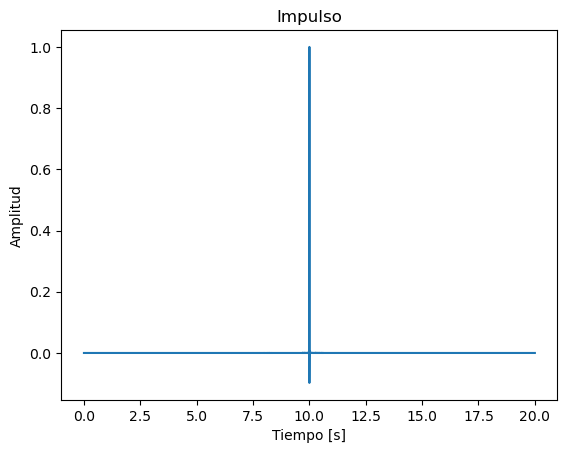

In [16]:
grafico_señal(impulso, title='Impulso')


Reproducir señal resultante.

In [19]:
sd.play(impulso)
sd.wait()


Comentar sobre el resultado obtenido. ¿Qué es lo que se esta escuchando? Realizar el mismo procedimiento con la señal descargada y el filtro inverso generado (para dicho sine sweep)

*completar*

Mencionar aspectos que diferencian los impulso generados en esta función, con los sintetizados.

*completar*

## Función filtros norma IEC61260

**Consigna**: Realizar una función que filtre todas las señales en octavas y tercio de octava según la norma IEC61260, con el objetivo de calcular los parámetros acústicos discriminando las frecuencias. 

Para lo cual utilizar las funciones del modulo [signals de scipy](https://docs.scipy.org/doc/scipy/reference/signal.html). Se adjunta el código capaz de calcular los coeficientes del filtro y aplicarlos a una señal. La función debe completarse con el código necesario para que este proceso se repita para cada una de las frecuencias centrales determinadas en la norma. Así mismo, el primer argumento de la función [iirfilter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.iirfilter.html) determina el grado del filtro. Evaluar el valor del mismo para que la frecuencia central de la banda coincida con las especificadas en la norma.

> Para ver una introducción breve a la implementación de filtros, usar el siguiente [documento](https://github.com/maxiyommi/signal-systems/blob/master/material_extra/Filtros/intro_filtros.ipynb).

In [33]:
def filtro(archivo, rango, fc, orden=4):
    """
    Aplica un filtro pasabanda a la señal de entrada, por octavas o por tercios de octava según la norma IEC61260.

    Parámetros:
    ----------
    archivo: string
       nombre del archivo .wav a filtrar.

    rango: string
       Pudiendo ser 1 para un filtrado por bandas de octava o 1/3 para un filtrado por tercios de octava.

    fc: int
        Frecuencia central en Hz.

    orden: int
        Orden del filtro.

    Returns:
    -------
    lista: lista
        Compuesta de la siguiente manera:
        1. frecuencia central fc de la banda que fue filtrada.
        2. array de la señal filtrada para esa fc.
        3. respuesta en frecuencia del filtro para esa fc.
        4. array con las frecuencias angulares.

    """
    archivo, fs = sf.read(archivo)

    if rango == 1:
        G = 1/2
    if rango == 1/3:
        G = 1/6

    factor = np.power(2, G)
    fc_Hz = fc

    # Extremos de la banda a partir de la frecuencia central

    f1_Hz = fc_Hz/factor
    f2_Hz = fc_Hz*factor

    if f2_Hz >= (fs/2):
        f2_Hz = (fs/2)-1

    # Extracción de los coeficientes del filtro
    b, a = signal.iirfilter(orden, [
                            2*np.pi*f1_Hz, 2*np.pi*f2_Hz], rs=60, btype='band', analog=True, ftype='butter')

    # Definición de sos para aplicar el filtro
    sos = signal.iirfilter(orden, [f1_Hz, f2_Hz], rs=60, btype='band',
                           analog=False, ftype='butter', fs=fs, output='sos')

    # Respuesta en frecuencia
    # w: array con las frecuencias angulares con las que h fue calculado.
    # h: array con la respuesta en frecuencia.
    w, h = signal.freqs(b, a)

    # Aplicación del filtro al audio
    filt = signal.sosfilt(sos, archivo)

    # Salidas
    lista = [fc_Hz, filt, h, w]
    return lista


Llamar a la función con alguna RI generada anteriormente.

In [34]:
RI_filtrado = filtro('impulso.wav', 1, 500)


Graficar el dominio espectral del resultado en una banda, utilizando el [software Audacity](https://www.audacityteam.org/) (Ayuda: [Plot Spectrum Audacity](https://manual.audacityteam.org/man/plot_spectrum.html))

In [63]:
# Completar


¿El resultado es el esperado? ¿Cumple con los requerimientos de la normativa?

*completar*

## Función conversión a escala logarítmica normalizada
Para visualizar correctamente la señal es necesario realizar una función que convierta la respuesta al impulso en escala logarítmica, utilizando la siguiente expresión:

\begin{equation}
    R(t) = 20\log_{10}\frac{A(t)}{A(t)_{max}}
\tag{11}
\end{equation}

Donde $A(t)$ es la señal que deseamos transformar de escala. **Consigna:** crear una función que convierta a escala logarítmica la RI que ingresa y devuelva un array con la señal resultante.

In [57]:
def escala_log(data, a=20):
    """
    Modifica la información de un numpy array a escala logarítmica.

    Parameters
    ----------
    data : numpy array
        Array con la información a escalar.
    a : int
        Coeficiente de multiplicación del logaritmo, valor por defecto de 20, para escalar valores de amplitud.

    Returns
    -------
    norm_log: numpy array 
        Audio original en escala logarítmica normalizada.

    """
    maximo = max(abs(data))
    norm = data/maximo  # Normalizado
    norm_log = -a*np.log10(norm)  # Conversión

    # Preguntar por el signo

    return norm_log


In [52]:
from funciones import ruidoRosa_voss

pink_noise = ruidoRosa_voss(10)


Llamar a la función con alguna de las señales generadas anteriormente.

In [55]:
pn_log = escala_log(pink_noise)


Visualizar la señal con la función creada en la primer entrega.

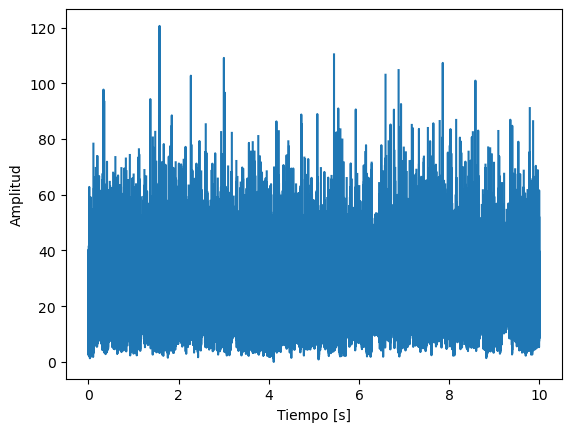

In [56]:
grafico_señal(pn_log)
